<h1 align="center">Part 2: Gold Price Analysis Using Fuzzy Logic and Clustering Techniques</h1>


In [ ]:
import skfuzzy as fuzz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from keras import initializers
# Compile the GAN
from keras.models import Model
from keras.layers import Input

In [ ]:
df=pd.read_excel("gold_futures.xlsx")

In [ ]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Price Movement'],
      dtype='object')

# 1. Implement Membership Functions


# step 1

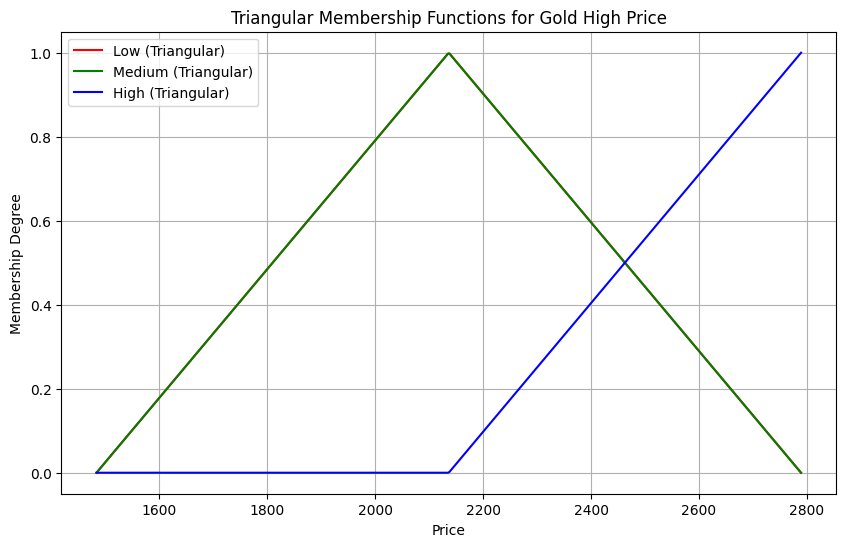

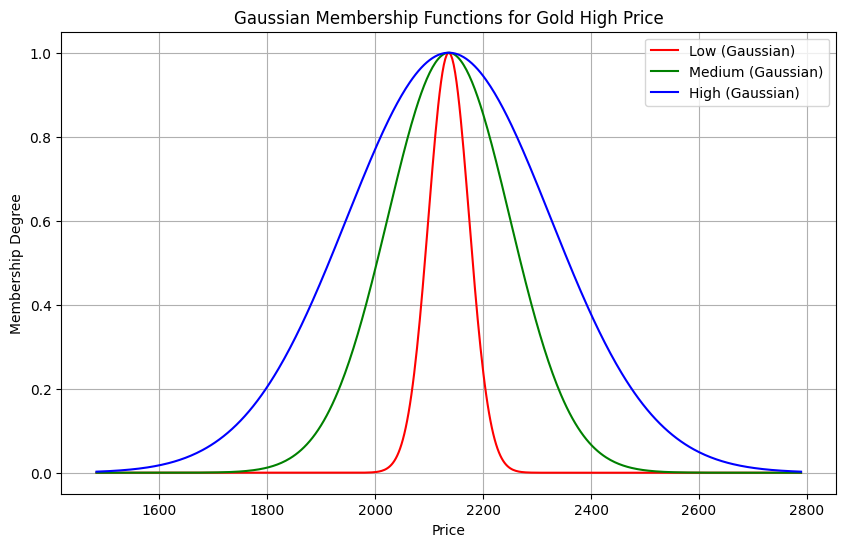

In [ ]:
high_price = df['High'].values

x = np.linspace(min(high_price), max(high_price), 500)

low_triangular = fuzz.trimf(x, [min(x), np.mean(x), np.max(x)])
medium_triangular = fuzz.trimf(x, [min(x), np.mean(x), max(x)])
high_triangular = fuzz.trimf(x, [np.mean(x), np.max(x), np.max(x)])

low_gaussian = fuzz.gaussmf(x, np.mean(x), 0.1 * np.std(x))
medium_gaussian = fuzz.gaussmf(x, np.mean(x), 0.3 * np.std(x))
high_gaussian = fuzz.gaussmf(x, np.mean(x), 0.5 * np.std(x))

plt.figure(figsize=(10, 6))
plt.plot(x, low_triangular, label='Low (Triangular)', color='r')
plt.plot(x, medium_triangular, label='Medium (Triangular)', color='g')
plt.plot(x, high_triangular, label='High (Triangular)', color='b')
plt.title('Triangular Membership Functions for Gold High Price')
plt.xlabel('Price')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(x, low_gaussian, label='Low (Gaussian)', color='r')
plt.plot(x, medium_gaussian, label='Medium (Gaussian)', color='g')
plt.plot(x, high_gaussian, label='High (Gaussian)', color='b')
plt.title('Gaussian Membership Functions for Gold High Price')
plt.xlabel('Price')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.show()

# 2. Apply C-Fuzzy Means (FCM) Clustering


# Step2

   Fuzziness Parameter (m)       FPC  Silhouette Score
0                      1.5  0.911914          0.511792
1                      2.0  0.796140          0.511241
2                      2.5  0.684634          0.511673


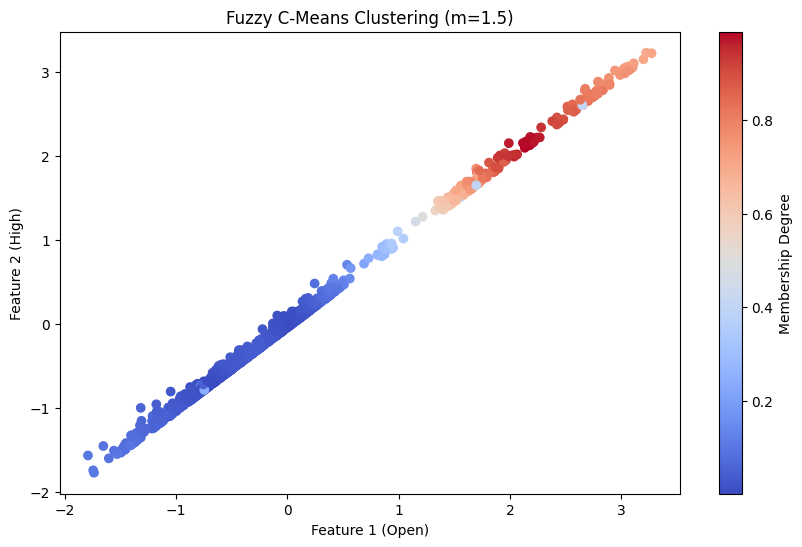

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from skfuzzy.cluster import cmeans

features = df[['Open', 'High', 'Low', 'Close', 'Volume']].values
features = StandardScaler().fit_transform(features)  # Normalize the data

m_values = [1.5, 2.0, 2.5]

fpc_scores = []
sil_scores = []

for m in m_values:

    cntr, u, _, _, _, _, _ = cmeans(features.T, 3, m, error=0.005, maxiter=2000)

    fpc = np.sum(u ** 2) / u.shape[1]
    fpc_scores.append(fpc)


    u_max = np.argmax(u, axis=0)
    silhouette = silhouette_score(features, u_max)
    sil_scores.append(silhouette)

results_df = pd.DataFrame({
    'Fuzziness Parameter (m)': m_values,
    'FPC': fpc_scores,
    'Silhouette Score': sil_scores
})

print(results_df)


plt.figure(figsize=(10, 6))
plt.scatter(features[:, 0], features[:, 1], c=u[0, :], cmap='coolwarm')
plt.title('Fuzzy C-Means Clustering (m=1.5)')
plt.xlabel('Feature 1 (Open)')
plt.ylabel('Feature 2 (High)')
plt.colorbar(label='Membership Degree')
plt.show()

# 3. Construct a Fuzzy Inference System (FIS)


# Step 3

C:\Users\FAST LAPTOP\AppData\Roaming\Python\Python312\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


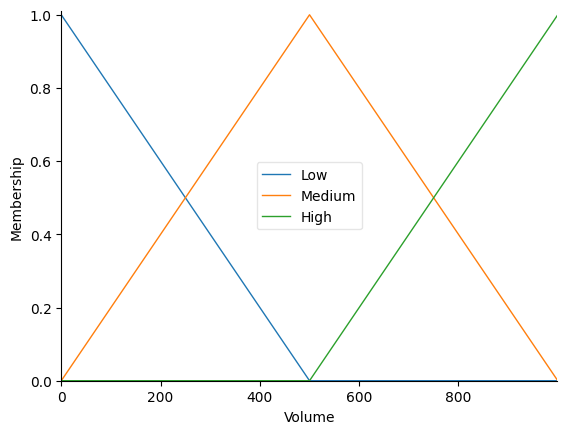

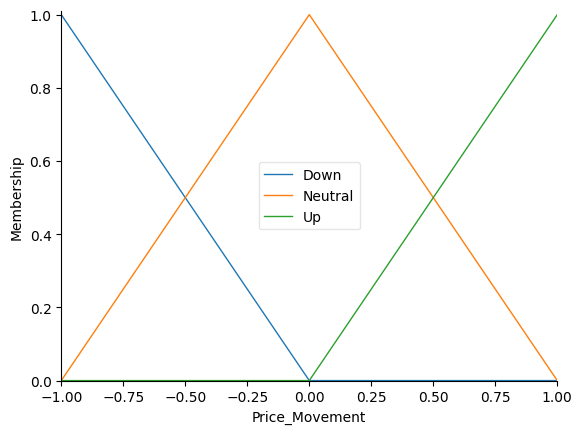

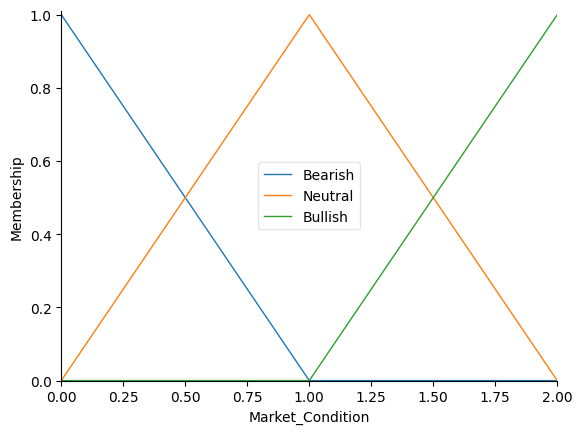

In [ ]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl

volume = ctrl.Antecedent(np.arange(0, 1000, 1), 'Volume')
price_movement = ctrl.Antecedent(np.arange(-1, 2, 1), 'Price_Movement')  # -1 (Down), 1 (Up)
market_condition = ctrl.Consequent(np.arange(0, 3, 1), 'Market_Condition')  # 0 (Bearish), 1 (Neutral), 2 (Bullish)

volume['Low'] = fuzz.trimf(volume.universe, [0, 0, 500])
volume['Medium'] = fuzz.trimf(volume.universe, [0, 500, 1000])
volume['High'] = fuzz.trimf(volume.universe, [500, 1000, 1000])

price_movement['Down'] = fuzz.trimf(price_movement.universe, [-1, -1, 0])
price_movement['Neutral'] = fuzz.trimf(price_movement.universe, [-1, 0, 1])
price_movement['Up'] = fuzz.trimf(price_movement.universe, [0, 1, 1])

market_condition['Bearish'] = fuzz.trimf(market_condition.universe, [0, 0, 1])
market_condition['Neutral'] = fuzz.trimf(market_condition.universe, [0, 1, 2])
market_condition['Bullish'] = fuzz.trimf(market_condition.universe, [1, 2, 2])

volume.view()
price_movement.view()
market_condition.view()

# Step:3.2

Market Condition: 1.611111111111111


C:\Users\FAST LAPTOP\AppData\Roaming\Python\Python312\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


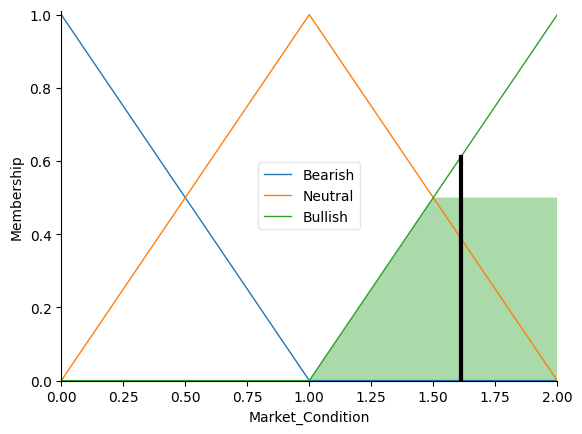

In [ ]:
rule1 = ctrl.Rule(volume['High'] & price_movement['Up'], market_condition['Bullish'])
rule2 = ctrl.Rule(volume['Medium'] & price_movement['Neutral'], market_condition['Neutral'])
rule3 = ctrl.Rule(volume['Low'] & price_movement['Down'], market_condition['Bearish'])

market_condition_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
market_condition_sim = ctrl.ControlSystemSimulation(market_condition_ctrl)

market_condition_sim.input['Volume'] = 750
market_condition_sim.input['Price_Movement'] = 1  # Up

market_condition_sim.compute()

print(f"Market Condition: {market_condition_sim.output['Market_Condition']}")
market_condition.view(sim=market_condition_sim)

In [ ]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,Price Movement
0,2020-01-02,1518.099976,1528.699951,1518.000000,1524.500000,1524.500000,214,Up
1,2020-01-03,1530.099976,1552.699951,1530.099976,1549.199951,1549.199951,107,Up
2,2020-01-06,1580.000000,1580.000000,1560.400024,1566.199951,1566.199951,416,Up
3,2020-01-07,1558.300049,1576.300049,1558.300049,1571.800049,1571.800049,47,Up
4,2020-01-08,1579.699951,1604.199951,1552.300049,1557.400024,1557.400024,236,Down
...,...,...,...,...,...,...,...,...
1240,2024-12-10,2662.300049,2698.199951,2661.000000,2697.600098,2697.600098,437,Up
1241,2024-12-11,2701.800049,2733.800049,2693.100098,2733.800049,2733.800049,3387,Up
1242,2024-12-12,2725.100098,2725.100098,2677.399902,2687.500000,2687.500000,2365,Down
1243,2024-12-13,2688.199951,2689.300049,2647.899902,2656.000000,2656.000000,1125,Down


# 4. Design an Advanced Fuzzy Logic System


# Step 4.1 :

C:\Users\FAST LAPTOP\AppData\Roaming\Python\Python312\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


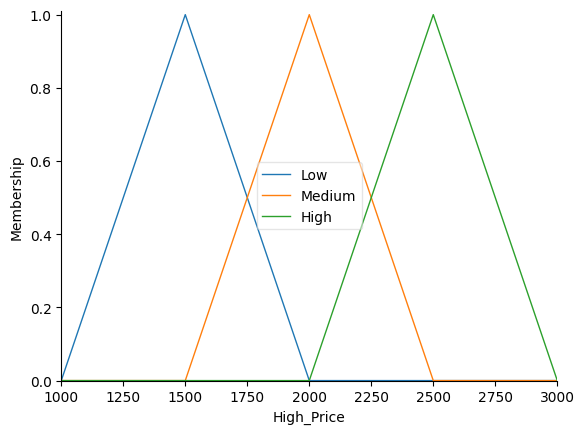

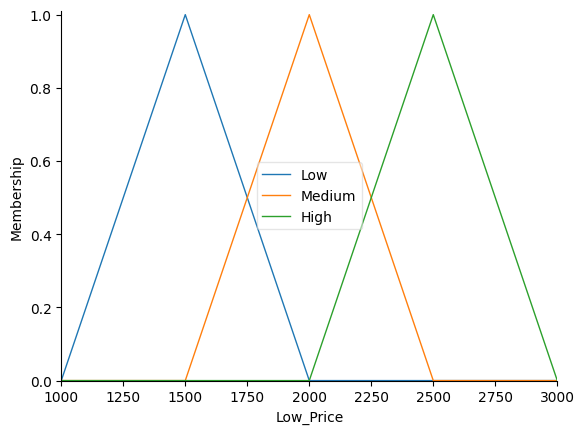

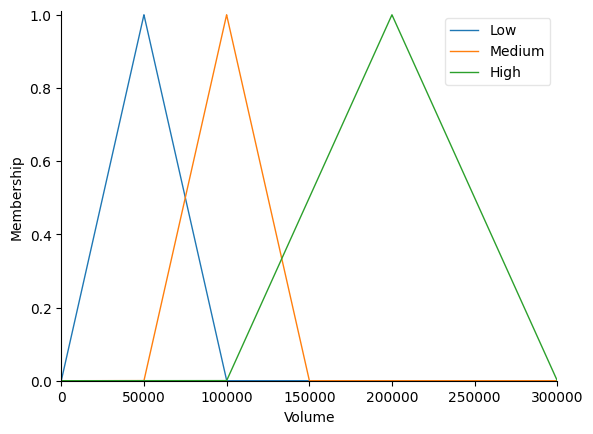

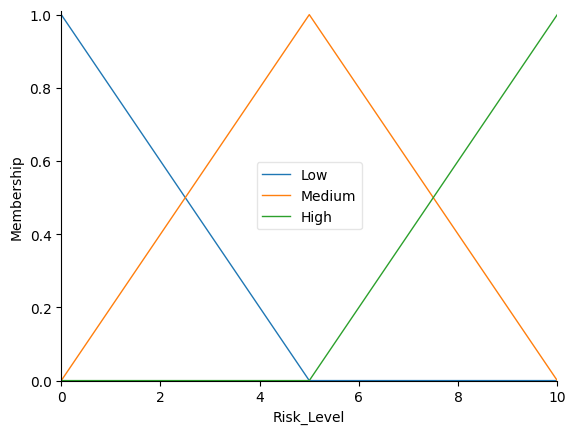

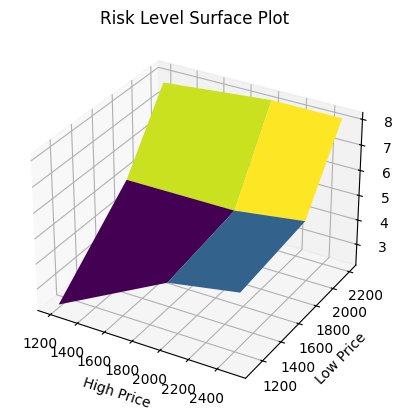

In [ ]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
from skfuzzy import control as ctrl

high_price = ctrl.Antecedent(np.arange(1000, 3001, 1), 'High_Price')
low_price = ctrl.Antecedent(np.arange(1000, 3001, 1), 'Low_Price')
volume = ctrl.Antecedent(np.arange(0, 300001, 1), 'Volume')

risk_level = ctrl.Consequent(np.arange(0, 11, 1), 'Risk_Level')

high_price['Low'] = fuzz.trimf(high_price.universe, [1000, 1500, 2000])
high_price['Medium'] = fuzz.trimf(high_price.universe, [1500, 2000, 2500])
high_price['High'] = fuzz.trimf(high_price.universe, [2000, 2500, 3000])

low_price['Low'] = fuzz.trimf(low_price.universe, [1000, 1500, 2000])
low_price['Medium'] = fuzz.trimf(low_price.universe, [1500, 2000, 2500])
low_price['High'] = fuzz.trimf(low_price.universe, [2000, 2500, 3000])

volume['Low'] = fuzz.trimf(volume.universe, [0, 50000, 100000])
volume['Medium'] = fuzz.trimf(volume.universe, [50000, 100000, 150000])
volume['High'] = fuzz.trimf(volume.universe, [100000, 200000, 300000])

risk_level['Low'] = fuzz.trimf(risk_level.universe, [0, 0, 5])
risk_level['Medium'] = fuzz.trimf(risk_level.universe, [0, 5, 10])
risk_level['High'] = fuzz.trimf(risk_level.universe, [5, 10, 10])


rule1 = ctrl.Rule(high_price['Low'] & low_price['Low'] & volume['Low'], risk_level['Low'])
rule2 = ctrl.Rule(high_price['Low'] & low_price['Low'] & volume['Medium'], risk_level['Low'])
rule3 = ctrl.Rule(high_price['Low'] & low_price['Low'] & volume['High'], risk_level['Medium'])
rule4 = ctrl.Rule(high_price['Low'] & low_price['Medium'] & volume['Low'], risk_level['Medium'])
rule5 = ctrl.Rule(high_price['Low'] & low_price['Medium'] & volume['Medium'], risk_level['Medium'])
rule6 = ctrl.Rule(high_price['Low'] & low_price['Medium'] & volume['High'], risk_level['High'])
rule7 = ctrl.Rule(high_price['Low'] & low_price['High'] & volume['Low'], risk_level['Medium'])
rule8 = ctrl.Rule(high_price['Low'] & low_price['High'] & volume['Medium'], risk_level['High'])
rule9 = ctrl.Rule(high_price['Low'] & low_price['High'] & volume['High'], risk_level['High'])
rule10 = ctrl.Rule(high_price['Medium'] & low_price['Low'] & volume['Low'], risk_level['Medium'])
rule11 = ctrl.Rule(high_price['Medium'] & low_price['Low'] & volume['Medium'], risk_level['Medium'])
rule12 = ctrl.Rule(high_price['Medium'] & low_price['Low'] & volume['High'], risk_level['High'])
rule13 = ctrl.Rule(high_price['Medium'] & low_price['Medium'] & volume['Low'], risk_level['Medium'])
rule14 = ctrl.Rule(high_price['Medium'] & low_price['Medium'] & volume['Medium'], risk_level['High'])
rule15 = ctrl.Rule(high_price['Medium'] & low_price['Medium'] & volume['High'], risk_level['High'])
rule16 = ctrl.Rule(high_price['Medium'] & low_price['High'] & volume['Low'], risk_level['High'])
rule17 = ctrl.Rule(high_price['Medium'] & low_price['High'] & volume['Medium'], risk_level['High'])
rule18 = ctrl.Rule(high_price['Medium'] & low_price['High'] & volume['High'], risk_level['High'])
rule19 = ctrl.Rule(high_price['High'] & low_price['Low'] & volume['Low'], risk_level['High'])
rule20 = ctrl.Rule(high_price['High'] & low_price['Low'] & volume['Medium'], risk_level['High'])
rule21 = ctrl.Rule(high_price['High'] & low_price['Low'] & volume['High'], risk_level['High'])
rule22 = ctrl.Rule(high_price['High'] & low_price['Medium'] & volume['Low'], risk_level['High'])
rule23 = ctrl.Rule(high_price['High'] & low_price['Medium'] & volume['Medium'], risk_level['High'])
rule24 = ctrl.Rule(high_price['High'] & low_price['Medium'] & volume['High'], risk_level['High'])
rule25 = ctrl.Rule(high_price['High'] & low_price['High'] & volume['Low'], risk_level['High'])
rule26 = ctrl.Rule(high_price['High'] & low_price['High'] & volume['Medium'], risk_level['High'])
rule27 = ctrl.Rule(high_price['High'] & low_price['High'] & volume['High'], risk_level['High'])

risk_level_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9,
                                     rule10, rule11, rule12, rule13, rule14, rule15, rule16, rule17,
                                     rule18, rule19, rule20, rule21, rule22, rule23, rule24, rule25, rule26, rule27])
risk_level_sim = ctrl.ControlSystemSimulation(risk_level_ctrl)


high_prices = [1200, 2000, 2500]
low_prices = [1100, 1800, 2200]
volumes = [1000, 70000, 150000]

results = []

for hp in high_prices:
    for lp in low_prices:
        for vol in volumes:
            risk_level_sim.input['High_Price'] = hp
            risk_level_sim.input['Low_Price'] = lp
            risk_level_sim.input['Volume'] = vol
            risk_level_sim.compute()
            results.append([hp, lp, vol, risk_level_sim.output['Risk_Level']])

high_price.view()
low_price.view()
volume.view()
risk_level.view()

X, Y = np.meshgrid(high_prices, low_prices)
Z = np.zeros_like(X, dtype=float)

for i in range(len(high_prices)):
    for j in range(len(low_prices)):
        risk_level_sim.input['High_Price'] = high_prices[i]
        risk_level_sim.input['Low_Price'] = low_prices[j]
        risk_level_sim.input['Volume'] = 50000
        risk_level_sim.compute()
        Z[i, j] = risk_level_sim.output['Risk_Level']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_xlabel('High Price')
ax.set_ylabel('Low Price')
ax.set_zlabel('Risk Level')
ax.set_title('Risk Level Surface Plot')

plt.show()

